# Model Evaluation

The goal of the evaluation part is to determine which methods to use on a particular problem. Error on the training data is not a good indicator of the performance on future data. 
Ideally, we would like to have: 
* a large amount of data for training the model in order to have a more accurate model
* a large amount of data for testing the model in order to have a more reliable evaluation and a more accurate estimation of the error.

We need some techniques to training and evaluate the models properly. 
In this notebook we will explore the most important techniques used to create properly a training and test set and how to conduct a fair evaluation of the model performance.

In this notebook we will first create an artificial dataset to show how the different techniques split the dataset. Then we will use the Iris dataset and the KNearestNeighborsClassifier to show how to proper evaluate the model.


In [1]:
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from utilities.ml_plot_utilities import  plot_bar_compare_stratification, plot_repeated_holdout_train_test_score
import numpy as np

In [2]:
# Load the dataset and retrieve features and target
iris = load_iris()
X, y = iris.data, iris.target

## **Evaluation procedure #1: Resubstitution error** 
Train and test on the entire dataset. The error is called *resubstitution error*. It is the error rate obtained by resubstituiting the training instances into a classifier constructed with the very same dataset. 

1. Train the model on the **entire dataset**.
2. Test the model on the **same dataset**, and evaluate how well we did by comparing the **predicted** response values with the **true** response values.

**In general, is hopelessly optimistic!**

In [3]:
knn = KNeighborsClassifier(n_neighbors=3)

# fit the model with data
knn.fit(X, y)

# predict the response values for the observations in X
y_pred=knn.predict(X)

# evaluate the model on the same dataset
print(f'Accuracy score: {accuracy_score(y, y_pred)}')
print(f'Resubstitution error rate: {round(1-accuracy_score(y, y_pred),2)}')

Accuracy score: 0.96
Resubstitution error rate: 0.04


## **Evaluation procedure #2: holdout method** 
The holdout method reserves a certain amount for testing and uses the rest for training.

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
X.shape, y.shape

((150, 4), (150,))

### Standard holdout method
We can now quickly sample a training set while holding out 30% of the data for testing (evaluating) our classifier.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [7]:
knn = KNeighborsClassifier(n_neighbors=3)

# fit the model with the training data
knn.fit(X_train, y_train)

# predict the response values for training and test data
y_train_pred=knn.predict(X_train)
y_test_pred=knn.predict(X_test)

print(f'Accuracy score on training data: {accuracy_score(y_train, y_train_pred)}')
print(f'Error rate on training data: {1-accuracy_score(y_train, y_train_pred)}')
print("===================================================")
print(f'Accuracy score on test data: {accuracy_score(y_test, y_test_pred)}')
print(f'Error rate on test data: {1-accuracy_score(y_test, y_test_pred)}')

Accuracy score on training data: 0.9904761904761905
Error rate on training data: 0.00952380952380949
Accuracy score on test data: 0.9111111111111111
Error rate on test data: 0.0888888888888889


### Stratified holdout method
The main issue in holdout estimation is that the classes in the training and test dataset could not be represented in equal proportions. We can use stratification to ensure that each class is represented in equal proportions in both subsets. 

To stratify, we need to pass the `stratify=y`, where `y` is the vector of the target values. 

In [8]:
_, _, y_train_non_stratified, _ = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=None)
_, _, y_train_stratified, _ = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y)

Label           Split   0   1   2
0      Non-Stratified  40  35  30
1          Stratified  35  35  35


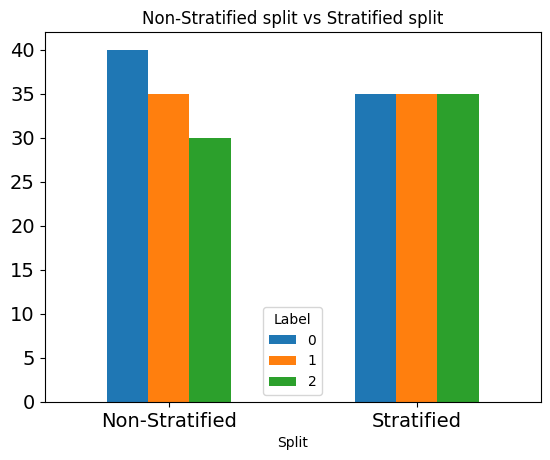

In [9]:
plot_bar_compare_stratification(y_train_non_stratified, y_train_stratified, return_plot=True, plot_summary_table=True)

### Repeated holdout method (stratified)
Holdout estimation can be made more reliable by repeating the process with different subsamples (usually 5 or 10 repetitions). In each iteration, a certain proportion is randomly selected for training (possibly with stratification). The error rates on the different iterations are averaged to yield an overall error rate. 

The issue of this approach is that different test sets may overlap!!

Mean Training Score: 0.9714
Standard Deviation Training Score: 0.0165
Mean Test Score: 0.9556
Standard Deviation Test Score: 0.0222


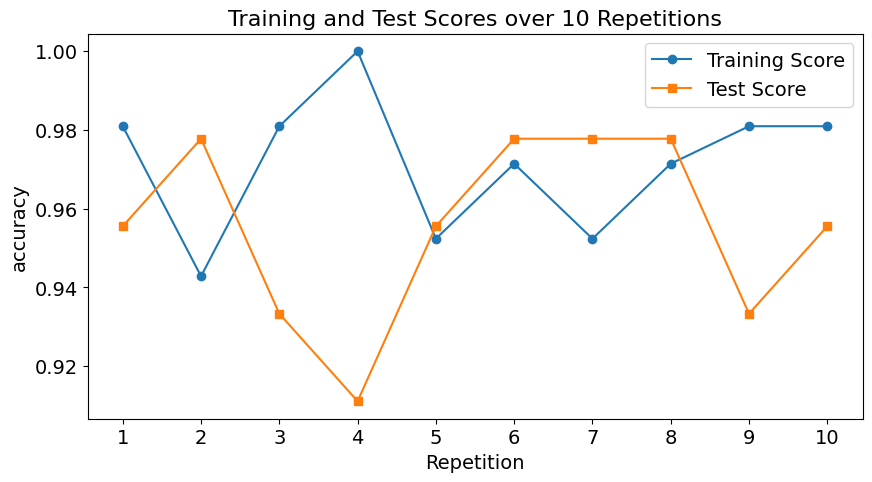

In [10]:
n_iter = 10
test_accuracy = np.zeros(n_iter)
train_accuracy = np.zeros(n_iter)
knn = KNeighborsClassifier(n_neighbors=3)

for i in range(n_iter):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y)
    knn.fit(X_train, y_train)
    
    # .score() computed the accuracy score by calling
    # .predict() and then accuracy_score()
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)   

print(f"Mean Training Score: {train_accuracy.mean():.4f}")
print(f"Standard Deviation Training Score: {train_accuracy.std():.4f}")
print(f"Mean Test Score: {test_accuracy.mean():.4f}")
print(f"Standard Deviation Test Score: {test_accuracy.std():.4f}")

plot_repeated_holdout_train_test_score(train_accuracy, test_accuracy, n_iter, 'accuracy')

## **Evaluation procedure #3: cross-validation method** 
Even if we use repetition, holdout method suffers from overlapping in the test set. We can use the so-called k-fold cross-validation.

1. Split the dataset into K **equal** partitions (or "folds").
2. Use fold 1 as the **testing set** and the union of the other folds as the **training set**.
3. Calculate **testing accuracy**.
4. Repeat steps 2 and 3 K times, using a **different fold** as the testing set each time.
5. Use the **average testing accuracy** as the estimate of out-of-sample accuracy.

### An introduction to `cross_val_score` and `cross_validate`

#### `cross_val_score`
The simplest way to use cross-validation is to call the `cross_val_score` helper function on the estimator and the dataset.

In [11]:
from sklearn.model_selection import cross_val_score
X, y = iris.data, iris.target
model = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(model, X, y, cv = 5)
print(scores)
print("%0.4f average accuracy with a standard deviation of %0.4f" % (scores.mean(), scores.std()))

[0.96666667 0.96666667 0.93333333 0.96666667 1.        ]
0.9667 average accuracy with a standard deviation of 0.0211


By default, the score computed at each CV iteration is the `score` method of the estimator. It is possible to change this by using the scoring parameter.

In [12]:
scores = cross_val_score(model, X, y, cv = 5, scoring='f1_macro')
print(scores)
print("%0.4f average 'f1_macro' with a standard deviation of %0.4f" % (scores.mean(), scores.std()))

[0.96658312 0.96658312 0.93265993 0.96658312 1.        ]
0.9665 average 'f1_macro' with a standard deviation of 0.0213


When the `cv` argument is an integer, `cross_val_score` uses the `KFold` or `StratifiedKFold`  strategies by default. We will see how to change strategies.

#### `cross_validate`
The `cross_validate` function differs from `cross_val_score` in two ways:
* It allows specifying multiple metrics for evaluation.
* It returns a dict containing fit-times, score-times (and optionally training scores, fitted estimators, train-test split indices) in addition to the test score.

If needed, we can also save the train score.

In [13]:
from sklearn.model_selection import cross_validate
X, y = iris.data, iris.target
model = KNeighborsClassifier(n_neighbors=3)
scoring = ['precision_macro', 'recall_macro']
scores = cross_validate(model, X, y, scoring=scoring, cv = 5, return_train_score=True)
sorted(scores.keys())
print(f"train_precision_macro: {scores['train_precision_macro']}")
print(f"train_recall_macro: {scores['train_recall_macro']}")
print("===============================================================================")
print(f"test_precision_macro: {scores['test_precision_macro']}")
print(f"test_recall_macro: {scores['test_recall_macro']}")

train_precision_macro: [0.95851574 0.95851574 0.96741855 0.96666667 0.95      ]
train_recall_macro: [0.95833333 0.95833333 0.96666667 0.96666667 0.95      ]
test_precision_macro: [0.96969697 0.96969697 0.94444444 0.96969697 1.        ]
test_recall_macro: [0.96666667 0.96666667 0.93333333 0.96666667 1.        ]


### K-fold cross-validation

In [14]:
from sklearn.model_selection import KFold
X = ["a", "b", "c", "d"]
kf = KFold(n_splits=2, shuffle=True)
for train, test in kf.split(X):
    print(f'train fold: {train} test fold: {test}')

train fold: [0 1] test fold: [2 3]
train fold: [2 3] test fold: [0 1]


In [15]:
X, y = iris.data, iris.target
model = KNeighborsClassifier(n_neighbors=3)
cv = KFold(n_splits=5, shuffle=True)
scores = cross_val_score(model, X, y, cv = cv, scoring='accuracy' )
print(scores)
print("%0.4f average accuracy with a standard deviation of %0.4f" % (scores.mean(), scores.std()))

[0.96666667 0.96666667 0.9        1.         1.        ]
0.9667 average accuracy with a standard deviation of 0.0365


### Stratified k-fold
Standard method for evaluation: stratified **ten-fold** cross-validation. Extensive experiments have shown that this is the best choice to get an accurate estimate. Stratification reduces the estimate's variance.

`StratifiedKFold` is a variation of k-fold which returns stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set.

* k = 10 if the dataset is large
* k = 5 otherwise

In [16]:
from sklearn.model_selection import StratifiedKFold
X, y = np.ones((100, 1)), np.hstack(([0] * 90, [1] * 10))
skf = StratifiedKFold(n_splits=10, shuffle=True)
for train, test in skf.split(X, y):
    print(f'train -  { np.bincount(y[train])}   |   test -  {np.bincount(y[test])}')

train -  [81  9]   |   test -  [9 1]
train -  [81  9]   |   test -  [9 1]
train -  [81  9]   |   test -  [9 1]
train -  [81  9]   |   test -  [9 1]
train -  [81  9]   |   test -  [9 1]
train -  [81  9]   |   test -  [9 1]
train -  [81  9]   |   test -  [9 1]
train -  [81  9]   |   test -  [9 1]
train -  [81  9]   |   test -  [9 1]
train -  [81  9]   |   test -  [9 1]


In [17]:
X, y = iris.data, iris.target
model = KNeighborsClassifier(n_neighbors=3)
cv = StratifiedKFold(n_splits=10, shuffle=True)
scores = cross_val_score(model, X, y, cv = cv, scoring='accuracy')
print(scores)
print("%0.4f average accuracy with a standard deviation of %0.4f" % (scores.mean(), scores.std()))

[0.93333333 1.         1.         1.         0.86666667 1.
 1.         0.86666667 1.         1.        ]
0.9667 average accuracy with a standard deviation of 0.0537


### Repeated k-fold
`RepeatedKFold` repeats K-Fold n times. It can be used when one requires running KFold n times, producing different splits in each repetition.

In [18]:
from sklearn.model_selection import RepeatedKFold
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
rkf = RepeatedKFold(n_splits=2, n_repeats=2)
for train, test in rkf.split(X):
    print(f'train fold: {train} test fold: {test}')

train fold: [1 3] test fold: [0 2]
train fold: [0 2] test fold: [1 3]
train fold: [0 2] test fold: [1 3]
train fold: [1 3] test fold: [0 2]


### Repeated stratified k-fold
`RepeatedStratifiedKFold` repeats stratified K-Fold n times with different randomization in each repetition. Standard approach: **Ten-fold** cross-validation is repeated **ten times** and results are averaged (reduces the variance).

In [19]:
from sklearn.model_selection import RepeatedStratifiedKFold
X, y = iris.data, iris.target
model = KNeighborsClassifier(n_neighbors=3)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10)
scores = cross_val_score(model, X, y, cv = cv, scoring='accuracy')
print(scores)
print("%0.4f average accuracy with a standard deviation of %0.4f" % (scores.mean(), scores.std()))

[0.93333333 1.         1.         1.         1.         1.
 0.93333333 0.93333333 0.86666667 1.         0.93333333 1.
 0.93333333 1.         1.         1.         0.93333333 0.93333333
 0.86666667 1.         0.93333333 1.         0.86666667 1.
 1.         0.93333333 1.         0.93333333 0.93333333 1.
 0.93333333 0.93333333 1.         1.         0.93333333 0.93333333
 1.         0.93333333 1.         1.         1.         1.
 0.93333333 0.93333333 1.         0.86666667 1.         1.
 0.93333333 1.         0.93333333 1.         1.         0.86666667
 1.         0.93333333 1.         0.93333333 1.         0.93333333
 0.93333333 1.         0.93333333 1.         0.93333333 1.
 0.93333333 1.         1.         0.86666667 1.         0.93333333
 0.93333333 1.         1.         0.93333333 1.         1.
 0.93333333 0.86666667 1.         1.         0.93333333 1.
 0.93333333 0.93333333 0.93333333 1.         0.86666667 1.
 0.93333333 0.93333333 1.         0.93333333 1.         1.
 1.         1.  

###  Time Series Split
`TimeSeriesSplit` is a variation of k-fold which returns first folds as a train set and the 
 th fold as a test set. Note that unlike standard cross-validation methods, successive training sets are supersets of those that come before them. Also, it adds all surplus data to the first training partition, which is always used to train the model.

This class can be used to cross-validate time series data samples that are observed at fixed time intervals.

In [20]:
from sklearn.model_selection import TimeSeriesSplit
X = np.array([[1, 2], 
              [3, 4], 
              [1, 2], 
              [3, 4], 
              [1, 2], 
              [3, 4]])

y = np.array([1, 2, 3, 4, 5, 6])
tscv = TimeSeriesSplit(n_splits=3)
for train, test in tscv.split(X):
    print(f'train fold: {train} test fold: {test}')
    print(f'X train: \n{X[train]}, y train: {y[train]}, X test: {X[test]}, y test: {y[test]},')
    print("=============================================================")

train fold: [0 1 2] test fold: [3]
X train: 
[[1 2]
 [3 4]
 [1 2]], y train: [1 2 3], X test: [[3 4]], y test: [4],
train fold: [0 1 2 3] test fold: [4]
X train: 
[[1 2]
 [3 4]
 [1 2]
 [3 4]], y train: [1 2 3 4], X test: [[1 2]], y test: [5],
train fold: [0 1 2 3 4] test fold: [5]
X train: 
[[1 2]
 [3 4]
 [1 2]
 [3 4]
 [1 2]], y train: [1 2 3 4 5], X test: [[3 4]], y test: [6],


## **Evaluation procedure #4: Leave-One-Out and Leave-P-Out method** 
`LeaveOneOut` (or LOO) is a simple cross-validation. Each learning set is created by taking all the samples except one, the test set being the sample left out. Thus, for samples, we have 
 different training sets and different test sets. This cross-validation procedure wastes little data as only one sample is removed from the training set. The results of all n judgement are averaged for determining the final error estimate.
 
**This is generally used only if the dataset is limited, let's say less than one hundred of samples.**
* Stratification is not possible
* Very computationally expensive


In [21]:
from sklearn.model_selection import LeaveOneOut
X = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
loo = LeaveOneOut()
for train, test in loo.split(X):
    print(f'train fold: {train} test fold: {test}')

train fold: [1 2 3 4 5 6 7 8 9] test fold: [0]
train fold: [0 2 3 4 5 6 7 8 9] test fold: [1]
train fold: [0 1 3 4 5 6 7 8 9] test fold: [2]
train fold: [0 1 2 4 5 6 7 8 9] test fold: [3]
train fold: [0 1 2 3 5 6 7 8 9] test fold: [4]
train fold: [0 1 2 3 4 6 7 8 9] test fold: [5]
train fold: [0 1 2 3 4 5 7 8 9] test fold: [6]
train fold: [0 1 2 3 4 5 6 8 9] test fold: [7]
train fold: [0 1 2 3 4 5 6 7 9] test fold: [8]
train fold: [0 1 2 3 4 5 6 7 8] test fold: [9]


In [22]:
X, y = iris.data, iris.target
model = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(model, X, y, cv = loo, scoring='accuracy')
print(f'Number of evaluations: {scores.shape}')
print("%0.4f average accuracy with a standard deviation of %0.4f" % (scores.mean(), scores.std()))

Number of evaluations: (150,)
0.9600 average accuracy with a standard deviation of 0.1960


`LeavePOut` is very similar to `LeaveOneOut` as it creates all the possible training/test sets by removing samples from the complete set. 


In [23]:
from sklearn.model_selection import LeavePOut
X = [1, 2, 3, 4, 5]
lpo = LeavePOut(p=2)
for train, test in lpo.split(X):
    print(f'train fold: {train} test fold: {test}')

train fold: [2 3 4] test fold: [0 1]
train fold: [1 3 4] test fold: [0 2]
train fold: [1 2 4] test fold: [0 3]
train fold: [1 2 3] test fold: [0 4]
train fold: [0 3 4] test fold: [1 2]
train fold: [0 2 4] test fold: [1 3]
train fold: [0 2 3] test fold: [1 4]
train fold: [0 1 4] test fold: [2 3]
train fold: [0 1 3] test fold: [2 4]
train fold: [0 1 2] test fold: [3 4]
